In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from uncertainties import ufloat
from uncertainties.umath import * 
from scipy.optimize import curve_fit
from scipy.integrate import trapz

import sys
sys.path.append('../src')  # Add the path to where the python scripts are located
from constants import *
from utils import *

In [2]:
# Esthetics for plots
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": 'serif',
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 18,
        "font.size": 18,
        "axes.linewidth":1,
        "axes.titlesize":16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 13,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "ytick.major.size": 5,     # major tick size in points
        "ytick.minor.size": 3,       # minor tick size in points
        "xtick.major.size": 7,     # major tick size in points
        "xtick.minor.size": 3,       # minor tick size in points
        "xtick.major.width": 1.4,     # major tick width in points
        "xtick.minor.width": 1.4,     # minor tick width in points
}
mpl.rcParams.update(nice_fonts)

### Define constants and parameters

In [3]:
distance = 100 * pc
dil = (4. * np.pi * distance**2 )

lsc = 1e18 # luminosity scale

# The nsc parameter is defined in constants.py!
# nsc = 1e15 # frequency scale --> MODIFY MANUALLY IN THE BB ROUTINE TO MATCH THIS VALUE!

nu1 = 1.157e15  # UVW1    
nu2 = 1.345e15  # UVM2 
nu = np.array( [nu1/nsc, nu2/nsc] )              # Transform to units of 1e15 Hz

flux1 = 1.64e0 * mJy    # in erg/s/cm2/Hz = Jy 
flux1_err = np.sqrt(0.03e0**2 + 0.05e0**2) * mJy  # in erg/s/cm2/Hz

flux2 = 7.97e-2 * mJy   # in erg/s/cm2/Hz 
flux2_err = np.sqrt(0.28e-2**2 + 0.05e-2**2) * mJy # in erg/s/cm2/Hz

print(f'flux1={flux1/mJy} ± {flux1_err/mJy:.2f} mJy')
print(f'flux2={flux2/mJy:.3f} ± {flux2_err/mJy:.3f} mJy')

flux1=1.64 ± 0.06 mJy
flux2=0.080 ± 0.003 mJy


### Fit the UV emission as a black body

In [4]:
# The star should also emit as a black body
T_star = 2200
R_star = 1.3 * au

# First calculate the BB SED with a normalization = 1
nu_fit = np.geomspace( min(nu)/100., max(nu)*100., 300)
norm_star = get_norm_nBB(R_star, T_star )
L_star =  nBB(nu_fit, norm_star, T_star)

L_bol = trapz(L_star, nu_fit*nsc) 
print(f'{L_bol=}') #6.31e36

L_bol=6.308570845376655e+36


/home/santiagodp/Trabajos/XR-AGBs/AGB_hotspot-SED/ipynbs/../src/utils.py:18: RuntimeWarning: overflow encountered in exp
  return norm * 2. * h * (nu2**3/c**2) / ( np.exp(h*nu2/k_B/T) - 1. )


In [5]:
#Define vectors with quantities to fit
lum_star = nBB(nu, norm_star, T_star)
print(lum_star/lsc)
#lum = np.array( [flux1*dil/lsc, flux2*dil/lsc] ) # Transform to units of 1e18 erg/s/Hz
lum = np.array( [(flux1*dil-lum_star[0])/lsc, (flux2*dil-lum_star[1])/lsc] ) # Transform to units of 1e18 erg/s/Hz, and fit only the exceeding flux 
lum_err = np.array( [flux1_err*dil/lsc, flux2_err*dil/lsc] ) # Transform to units of 1e18 erg/s/Hz
print(lum)

# Define seed values for the fit
seed = np.array([1e5,3e3]) # norm, T
bs = ((0, 1e3), (1e16, 1e4)) # ( min values, max values ) = ( (min_norm, min_T), (max_norm, max_T) )

# Fit function to the data  
popt, pcov = curve_fit(nBB, xdata=nu, ydata=lum, p0=seed, sigma=lum_err, bounds=bs, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))

for i in range(len(perr)):
    print('fit: ' + str(popt[i])+' +- '+str(perr[i]))
    
# prepare confidence level curves
nstd = 1.0 # to draw 1-sigma intervals
popt_up = popt + nstd * perr
popt_dw = popt - nstd * perr

fit = nBB(nu_fit, *popt)
fit_up = nBB(nu_fit, *popt_up)
fit_dw = nBB(nu_fit, *popt_dw)

T = ufloat(popt[1], perr[1])

print(f'\n Temperature: {T = :.2u}')

integral = trapz(fit*lsc, nu_fit*nsc) 
print(f' Bolometric luminosity: L_UV = {integral:.1E}')
    
R = sqrt( integral / (4.0*np.pi*sigma_SB*T**4) )
print(f' Radius: R = {R/au:.3f} AU')

[3.72638244e-03 9.69054684e-05]
[0.01589642 0.00085672]
fit: 718378054.1287086 +- 285874151.42500824
fit: 2675.374343361581 +- 46.9612522364206

 Temperature: T = 2675+/-47
 Bolometric luminosity: L_UV = 6.6E+35
 Radius: R = 0.285+/-0.010 AU


### Plot the data and fit

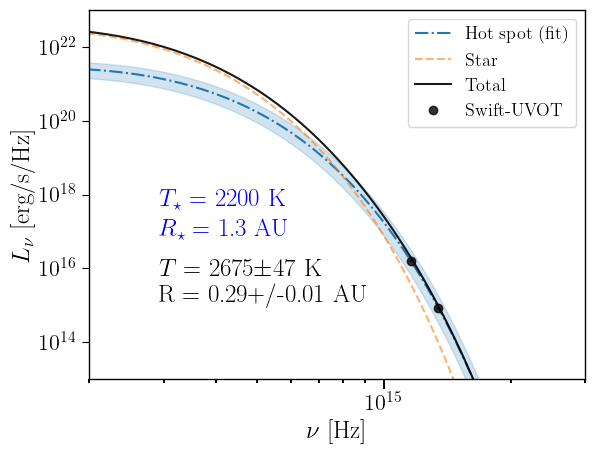

In [6]:
fig, ax = plt.subplots(1)
plt.title('')
ax.set_xlabel(r'$\nu$ [Hz]')
ax.set_ylabel(r'$L_\nu$ [erg/s/Hz]')
plt.xlim(2e14, 3e15)
plt.ylim(1e13, 1e23)
#plt.xlim(1e15, 1.6e15)
#plt.ylim(1e14, 5e16)

plt.plot(nu_fit*nsc, fit*lsc, linestyle='-.', label='Hot spot (fit)', color='C0')
ax.fill_between(nu_fit*nsc, fit_up*lsc, fit_dw*lsc, alpha=.2, label='', color='C0')

plt.plot(nu_fit*nsc, L_star, linestyle='--', alpha=0.6, label='Star', color='C1')

plt.plot(nu_fit*nsc, L_star+fit*lsc, color='black', linestyle='-', alpha=0.9, label='Total')

plt.errorbar(nu*nsc, lum*lsc, yerr=lum_err*lsc, ecolor='k', alpha=0.8, fmt='none')
plt.plot(nu*nsc, lum*lsc, 'ko', alpha=0.8, label = 'Swift-UVOT')


plt.legend(loc='best')
ax.loglog()
ax.annotate(r'$T =$ ' + str(round(popt[1])) + '$\pm$' + str(round(perr[1])) + ' K',
            xy=(0.1, 0.22), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='bottom')

ax.annotate(f'R = {R/au:.2f} AU',
            xy=(0.1, 0.14), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='bottom')

ax.annotate(r'$T_\star =$ ' + str(round(T_star)) + ' K',
            xy=(0.1, 0.4), xycoords='axes fraction', color='blue',
            xytext=(20, 20), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='bottom')

ax.annotate(r'$R_\star =$ ' + str(round(R_star/au, 1)) + ' AU',
            xy=(0.1, 0.32), xycoords='axes fraction', color='blue',
            xytext=(20, 20), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='bottom')

plt.show()

fig.savefig('UV_fit.pdf', bbox_inches='tight', pad_inches = 0)

### Explore the intrinsic emission from a star with a hot spot

In [7]:
T_beam = 3500 # K , measured brightness temperature in the beam with the hot spot
R_beam = 0.5 * au  # Beam size, to be updated
print(f'{R_beam/R_star=}')

# x is the normalized size of the hot spot
x_min = 0.2        # Arbitrary
x_max = 1.0        # R_beam/R_star

xs = np.geomspace(x_min, x_max, 6) 

# The temperature of the hot spot has to be consistent with the assumed stellar temperature 
# and the average temperature measured in the beam (T_beam). When x=x_max, T_hot = T_beam
T_hots = np.ones_like(xs) # just to have the same dimension
i = 0
for x in xs:
    T_hots[i] = T_star + (T_beam - T_star)/x**2
    i = i+1
    
print(xs)
print(T_hots) 

R_beam/R_star=0.38461538461538464
[0.2        0.27594593 0.38073079 0.52530556 0.72477966 1.        ]
[34700.         19272.43072862 11168.2427995   6911.06781391
  4674.75012033  3500.        ]


In [13]:
# Calculate the emission from the star ignoring the hot spot
norm_star = get_norm_nBB(R_star, T_star )
L_star = nBB(nu_fit, norm_star, T_star)

L_bol = trapz(L_star, nu_fit*nsc) 
print(f'{L_bol=}')

L_bol=6.308570845376655e+36


In [37]:
L_sts = []
L_hots = []
for x,T_hot in zip(xs,T_hots):
    #print(x, T_hot)
    
    # First the stellar luminosity, corrected by the hot spot size
    L_sts.append( L_star * (1. - (x * R_beam/R_star)**2) ) # Remove the fraction occupied by the hot spot
    
    # Second the hot spot luminosity
    R_hot = x * R_beam
    norm_hot = get_norm_nBB(R_hot, T_hot )
    L_hot = nBB(nu_fit, norm_hot, T_hot)
    L_hots.append(L_hot)

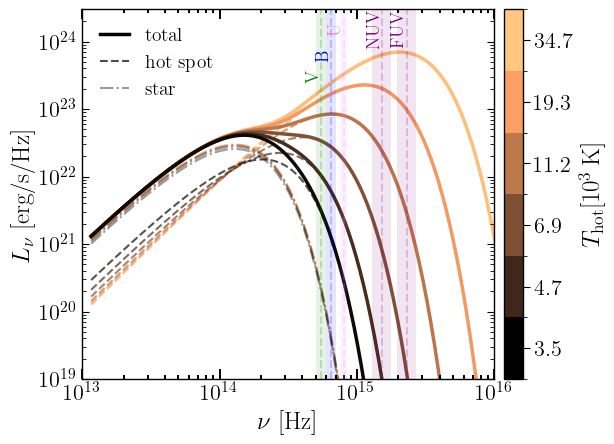

In [38]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title('')
ax.set_xlabel(r'$\nu$ [Hz]')
ax.set_ylabel(r'$L_\nu$ [erg/s/Hz]')
xmin, xmax = 1e13, 1e16
ymin, ymax = 1e19, 3e24 
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(xs)
color_vector = np.linspace(0.05,0.95,n)
colors = plt.cm.copper_r(color_vector) 

# Generate a discrete colorbar for "n" points
co = np.arange(1, n+1) 
cmap = matplotlib.colormaps['copper_r'].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n+1)+0.5,n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Create some sample lines
line1 = Line2D([0], [0], color='black', linestyle='-', linewidth=2.5, label='total')
line2 = Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, alpha=0.7, label='hot spot')
line3 = Line2D([0], [0], color='black', linestyle='-.', linewidth=1.5, alpha=0.4, label='star')

# Create a list of handles and labels for the legend
handles = [line1, line2, line3]
labels = [line1.get_label(), line2.get_label(), line3.get_label()]

# Plot for each value of M
for i in range(n):
    plt.plot(nu_fit*nsc, L_sts[i]+L_hots[i], ls='-', color=colors[i], linewidth=2.5, alpha=1, label='', zorder=1)
    plt.plot(nu_fit*nsc, L_hots[i], ls='--', color=colors[i], linewidth=1.5, label='', alpha=0.7, zorder=1)
    plt.plot(nu_fit*nsc, L_sts[i], ls='-.', color=colors[i], linewidth=1.5, label='', alpha=0.4, zorder=1)
    
# Add the observed data
#plt.errorbar(nu*nsc, lum*lsc, yerr=lum_err*lsc, ecolor='C0', alpha=0.8, fmt='none')
#plt.plot(nu*nsc, lum*lsc, 'o', color='C0', alpha=0.8, label = 'Swift-UVOT')
    
# Add the custom legend box
plt.legend(handles, labels, loc='best', fontsize=14, handlelength=1.5, frameon=False)
    
ax.loglog() 

#cbar = fig.colorbar(sm, ticks=co, label=r"$T_\mathrm{hot} [K]$", pad=0.02, ax=plt.gca())
#zs_labels = ['{:.1e}'.format(T_hot) for T_hot in T_hots]
cbar = fig.colorbar(sm, ticks=co, label=r"$T_\mathrm{hot} [10^3 \, \mathrm{K}]$", pad=0.02, ax=plt.gca())
zs_labels = ['{:.1f}'.format(T_hot/1e3) for T_hot in T_hots]
cbar.ax.set_yticklabels(zs_labels)  # vertically oriented colorbar
cbar.ax.invert_yaxis()

# Add a rectangle showing the common spectral bands (CHECK THE NUMBERS!!!!!)
bands = [{'name': 'FUV', 'start': 1.947e15, 'width': 7.335e14, 'color': 'purple', 'pos': ymin + (ymax-ymin)/2.},
         {'name': 'NUV', 'start': 1.295e15, 'width': 4.631e14, 'color': 'purple', 'pos': ymin + (ymax-ymin)/2.},
         {'name': 'U', 'start': 7.498e14, 'width': 1.0e14, 'color': 'violet', 'pos': ymin + (ymax-ymin)/2.},
         {'name': 'B', 'start': 6.0e14, 'width': 1.0e14, 'color': 'blue', 'pos': ymin + (ymax-ymin)/5.},
         {'name': 'V', 'start': 5.0e14, 'width': 1.0e14, 'color': 'green', 'pos': ymin + (ymax-ymin)/10.}]
#{'name': 'X-R', 'start': 7.254e16, 'width': 1.693e17, 'color': 'blue', 'pos': ymin + (ymax-ymin)/2.},
 

for band in bands:
    # Add the rectangle
    ax.add_patch(Rectangle((band['start'], ymin), band['width'], ymax-ymin,
                           edgecolor='none', facecolor=band['color'], alpha=0.1, lw=0))
    # Add the vertical dashed line with the text
    ax.axvline(band['start'] + band['width']/2, ymin=0, ymax=1, color=band['color'], alpha=0.2, linestyle='--')
    ax.text(band['start'] + band['width']/2+0.9, band['pos'], band['name'], color=band['color'],
            ha='right', va='center', rotation='vertical', fontsize=13)
    
ax.tick_params(axis="both", which="both", right=True, left=True, top=True, direction="in")

plt.show()
fig.savefig('hot-spot_seds.pdf', bbox_inches='tight', pad_inches = 0.001)

### Estimate the minimum mass that is required for the emission to be optically thick

In [39]:
# Define the size of the hot spot assuming it is a cyllinder of radius "R" and depth "h"
h_scale = 0.1
R_hot = xs * R_beam
h_hot = R_hot * h_scale
vol_hot = np.pi * R_hot**2 * h_hot
rho_hot = 1.0 # --> write the condition: tau = alpha_ff(nu, rho_hot,...) * h_hot = 1
M_hot = rho_hot * vol_hot

print(vol_hot)

[1.05182782e+36 2.76265501e+36 7.25619021e+36 1.90585853e+37
 5.00579043e+37 1.31478477e+38]
